In [57]:
%pip install -q pandas matplotlib openpyxl



Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "State_to_State_Migration_Table_2023_T13.xlsx"  # must be in the same folder as this notebook


In [3]:
raw = pd.read_excel(FILE, sheet_name="Table", header=None)
raw.iloc[:15, :15]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Table with row headers in column A and column ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Table 1. State-to-State Migration Flows1: 2023...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Universe: Population 1 year and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Current residence in,Population \n1 year and over,NaN,Same residence \n1 year ago,NaN,Different residence 1 year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,Same state of residence 1 year ago,NaN,Different state of residence 1 year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Total,NaN,Alabama,NaN,Alaska,NaN,Arizona,NaN
7,NaN,Estimate,MOE (±),Estimate,MOE (±),Estimate,MOE (±),Estimate,MOE (±),Estimate,MOE (±),Estimate,MOE (±),Estimate,MOE (±)
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,United States2,331383809,36464,291381909,229417,30026911,187851,7550415,76295,99663,10169,35800,7234,193670,12984


In [5]:
# Build MultiIndex columns from rows 6 and 7
top = raw.iloc[6].reset_index(drop=True)
bottom = raw.iloc[7].reset_index(drop=True)
mi_cols = pd.MultiIndex.from_arrays([top, bottom])

df = raw.copy()
df.columns = mi_cols

# Find the block of rows for states (Alabama .. Wyoming) using the first column of the *raw* sheet
col0 = raw.iloc[:, 0].astype(str).str.strip()
row_start = col0[col0.eq("Alabama")].index.min()
row_end   = col0[col0.eq("Wyoming")].index.max()
row_start, row_end


(11, 61)

In [7]:
states_df = df.iloc[row_start:row_end+1].reset_index(drop=True)

# Current state names live in the first physical column (whose top/bottom headers are NaN)
current_states = states_df.iloc[:, 0].astype(str).str.strip()
current_states.head()


0       Alabama
1        Alaska
2       Arizona
3      Arkansas
4    California
Name: (nan, nan), dtype: object

In [9]:
# All columns where the lower-level header == 'Estimate' and top-level header exists
estimate_cols = [c for c in df.columns if isinstance(c, tuple) and c[1] == "Estimate" and pd.notna(c[0])]
top_names = [c[0].strip() for c in estimate_cols]

# Indices for Alabama..Wyoming in that header list (includes DC in between)
start_idx = next(i for i, n in enumerate(top_names) if n == "Alabama")
end_idx   = next(i for i, n in enumerate(top_names) if n == "Wyoming")

state_estimate_cols = estimate_cols[start_idx:end_idx+1]  # only 50 states + DC

# Build the wide flows table (rows = current, cols = previous)
flows_wide = states_df[state_estimate_cols].copy()
flows_wide.columns = [c[0].strip() for c in state_estimate_cols]  # clean to simple names
flows_wide.index = current_states
flows_wide = flows_wide.apply(pd.to_numeric, errors="coerce")

# Ensure the matrix is square on the same set of states
valid_states = [s for s in flows_wide.columns if s in flows_wide.index]
flows_wide = flows_wide.loc[valid_states, valid_states]

flows_wide.shape, flows_wide.index[:5].tolist(), flows_wide.columns[:5].tolist()


((51, 51),
 ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
 ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'])

In [13]:
# flows_wide is your 51x51 matrix from Step 5
flows_long = (
    flows_wide
      .stack()                             # wide -> long
      .rename("Movers_Estimate")
      .reset_index()
      .rename(columns={"level_0":"Current_State", "level_1":"Previous_State"})
)

flows_long.head(10)



,"(nan, nan)",Previous_State,Movers_Estimate
0,Alabama,Alaska,780.0
1,Alabama,Arizona,4470.0
2,Alabama,Arkansas,1584.0
3,Alabama,California,4921.0
4,Alabama,Colorado,1601.0
5,Alabama,Connecticut,283.0
6,Alabama,Delaware,330.0
7,Alabama,District of Columbia,273.0
8,Alabama,Florida,17515.0
9,Alabama,Georgia,19270.0


In [17]:
# Rebuild long safely and force the column names
flows_long = (
    flows_wide
      .stack()
      .rename("Movers_Estimate")
      .reset_index()
)

# Force consistent names regardless of what reset_index produced
flows_long.columns = ["Current_State", "Previous_State", "Movers_Estimate"]

# sanity check
print(flows_long.columns.tolist())
flows_long.head()



['Current_State', 'Previous_State', 'Movers_Estimate']


,Current_State,Previous_State,Movers_Estimate
0,Alabama,Alaska,780.0
1,Alabama,Arizona,4470.0
2,Alabama,Arkansas,1584.0
3,Alabama,California,4921.0
4,Alabama,Colorado,1601.0


In [19]:
inbound  = flows_long.groupby("Current_State")["Movers_Estimate"].sum().rename("Inbound_Movers")
outbound = flows_long.groupby("Previous_State")["Movers_Estimate"].sum().rename("Outbound_Movers")

net = pd.concat([inbound, outbound], axis=1).fillna(0)
net["Net_Migration"] = net["Inbound_Movers"] - net["Outbound_Movers"]

top10_gainers = net.sort_values("Net_Migration", ascending=False).head(10)
top10_losers  = net.sort_values("Net_Migration", ascending=True).head(10)

top10_gainers, top10_losers


(                Inbound_Movers  Outbound_Movers  Net_Migration
 Texas                 611942.0         478570.0       133372.0
 Florida               636933.0         510925.0       126008.0
 North Carolina        339255.0         232663.0       106592.0
 South Carolina        203674.0         135007.0        68667.0
 Arizona               256203.0         193670.0        62533.0
 Georgia               310452.0         250484.0        59968.0
 Indiana               150649.0         120876.0        29773.0
 Oklahoma              107679.0          84309.0        23370.0
 Virginia              276161.0         253240.0        22921.0
 Tennessee             203156.0         180407.0        22749.0,
                Inbound_Movers  Outbound_Movers  Net_Migration
 California           422075.0         690127.0      -268052.0
 New York             302835.0         481544.0      -178709.0
 Illinois             203758.0         297005.0       -93247.0
 New Jersey           156335.0         2255

In [21]:
flows_long.to_csv("state_to_state_migration_2023_long.csv", index=False)
net.reset_index().rename(columns={"index": "State"}).to_csv("state_net_migration_2023.csv", index=False)

print("Saved: state_to_state_migration_2023_long.csv")
print("Saved: state_net_migration_2023.csv")


Saved: state_to_state_migration_2023_long.csv
Saved: state_net_migration_2023.csv


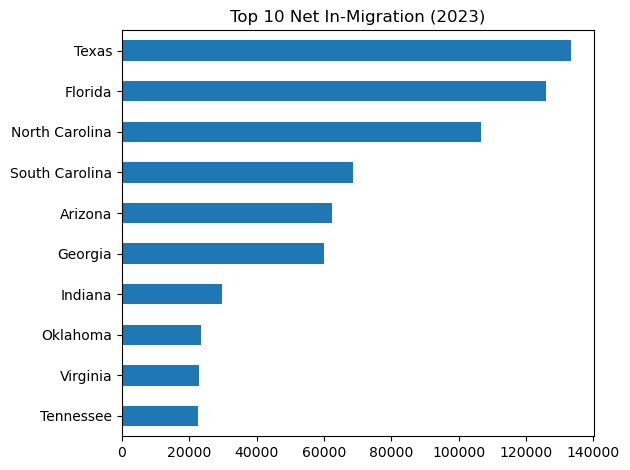

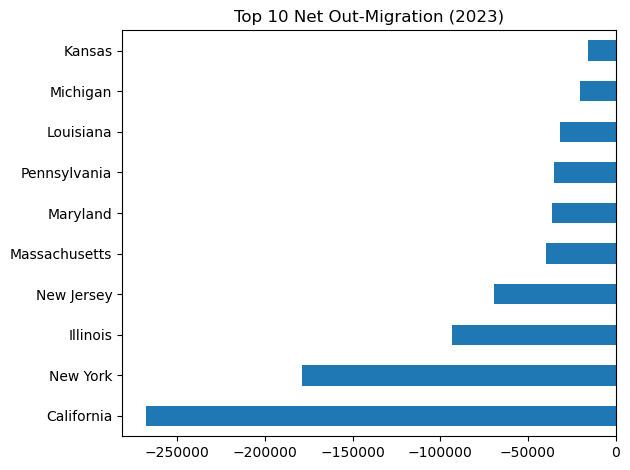

In [23]:
# Top In
plt.figure()
top10_gainers.sort_values("Net_Migration", ascending=True)["Net_Migration"].plot(
    kind="barh", title="Top 10 Net In-Migration (2023)"
)
plt.tight_layout()

# Top Out
plt.figure()
top10_losers.sort_values("Net_Migration", ascending=True)["Net_Migration"].plot(
    kind="barh", title="Top 10 Net Out-Migration (2023)"
)
plt.tight_layout()
plt.show()


In [25]:
# Load net migration CSV
net_df = pd.read_csv("state_net_migration_2023.csv")

# Load population data from original Excel (population = column 1 "Population 1 year and over")
raw = pd.read_excel("State_to_State_Migration_Table_2023_T13.xlsx", sheet_name="Table", header=None)

# Find start/end for states
col0 = raw.iloc[:, 0].astype(str).str.strip()
row_start = col0[col0.eq("Alabama")].index.min()
row_end   = col0[col0.eq("Wyoming")].index.max()

# Slice state rows
pop_df = raw.iloc[row_start:row_end+1, [0, 1]].copy()
pop_df.columns = ["State", "Population"]

# Merge population into net_df
merged = pd.merge(net_df, pop_df, on="State", how="left")

# Calculate Net_Migration_Rate
merged["Net_Migration_Rate"] = (merged["Net_Migration"] / merged["Population"]) * 100

# Calculate Migration_Efficiency
merged["Migration_Efficiency"] = (
    (merged["Inbound_Movers"] - merged["Outbound_Movers"]) /
    (merged["Inbound_Movers"] + merged["Outbound_Movers"])
)

# Save final analysis file
merged.to_csv("state_migration_analysis_2023.csv", index=False)

# Display sorted head by Net_Migration_Rate
merged.sort_values("Net_Migration_Rate", ascending=False).head()


,State,Inbound_Movers,Outbound_Movers,Net_Migration,Population,Net_Migration_Rate,Migration_Efficiency
34,North Dakota,34415.0,20814.0,13601.0,774985,1.755002,0.246266
40,South Carolina,203674.0,135007.0,68667.0,5319249,1.290915,0.202748
45,Vermont,26743.0,19151.0,7592.0,642670,1.181322,0.165425
33,North Carolina,339255.0,232663.0,106592.0,10719307,0.994393,0.186376
7,Delaware,39006.0,29121.0,9885.0,1022638,0.966618,0.145097


In [27]:
# Load the analysis file we just created
analysis_df = pd.read_csv("state_migration_analysis_2023.csv")

# Sort by Net_Migration_Rate descending (or change order as you like)
analysis_sorted = analysis_df.sort_values("Net_Migration_Rate", ascending=False)

# Display the full listing (all 51 rows: 50 states + DC)
# In Jupyter, this will show the entire DataFrame (if large, you might limit)
analysis_sorted

# If you want a cleaner table with only the relevant columns:
cols = ["State", "Population", "Inbound_Movers", "Outbound_Movers", 
        "Net_Migration", "Net_Migration_Rate", "Migration_Efficiency"]
analysis_sorted[cols]


,State,Population,Inbound_Movers,Outbound_Movers,Net_Migration,Net_Migration_Rate,Migration_Efficiency
34,North Dakota,774985.0,34415.0,20814.0,13601.0,1.755002,0.246266
40,South Carolina,5319249.0,203674.0,135007.0,68667.0,1.290915,0.202748
45,Vermont,642670.0,26743.0,19151.0,7592.0,1.181322,0.165425
33,North Carolina,10719307.0,339255.0,232663.0,106592.0,0.994393,0.186376
7,Delaware,1022638.0,39006.0,29121.0,9885.0,0.966618,0.145097
12,Idaho,1945004.0,81708.0,64970.0,16738.0,0.860564,0.114114
2,Arizona,7362464.0,256203.0,193670.0,62533.0,0.849349,0.139001
19,Maine,1385562.0,38089.0,27227.0,10862.0,0.783942,0.166299
36,Oklahoma,4011072.0,107679.0,84309.0,23370.0,0.582637,0.121726
9,Florida,22395466.0,636933.0,510925.0,126008.0,0.562650,0.109777


In [2]:
import pandas as pd

# load long flows
flows_long = pd.read_csv("state_to_state_migration_2023_long.csv")

# drop same-state flows
flows_long = flows_long[flows_long["Current_State"] != flows_long["Previous_State"]]

# rank origins per destination (Current_State)
flows_long["Rank"] = (
    flows_long
    .sort_values(["Current_State","Movers_Estimate"], ascending=[True, False])
    .groupby("Current_State")
    .cumcount() + 1
)

top3_inbound = flows_long[flows_long["Rank"] <= 3].copy()
top3_inbound.to_csv("top3_inbound_by_state_2023.csv", index=False)
